In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=3
use_logy=False
num_context, num_extra_target = 24*2*3, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()

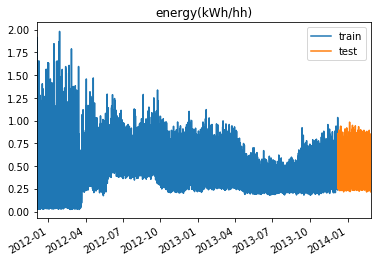

In [7]:
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Dataloaders

In [8]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [9]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [10]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 120, 17]), torch.Size([32, 120, 1]))

In [11]:
from src.models.model import LatentModel
model = LatentModel(
    x_dim=x.shape[-1], 
    y_dim=y.shape[-1], 
#     hidden_dim=64,
#     latent_dim=64,
#     dropout=0.,
#     min_std=1e-3,
#     attention_dropout=0,
#     num_heads=8,
#     n_latent_encoder_layers=3,
#     n_det_encoder_layers=3,
#     n_decoder_layers=3,
#     attention_layers=2,
#     latent_enc_self_attn_type="ptmultihead", 
#     det_enc_self_attn_type="ptmultihead",
#     det_enc_cross_attn_type="ptmultihead",
#     use_self_attn=True,
#     batchnorm=False,
#     use_lvar=True,
#     use_deterministic_path=False
    

    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="ptmultihead",
    det_enc_self_attn_type="ptmultihead",
    det_enc_cross_attn_type="ptmultihead",
    min_std=1e-3,
    use_lvar=True,
    use_self_attn=True,
).to(device)

optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=4)


In [12]:
from torchsummaryX import summary
data = next(iter(loader_train))
data = [d.to(device) for d in data]
context_x, context_y, target_x, target_y = data
with torch.no_grad():
    model.eval()
    summary(model, context_x, context_y, target_x, target_y)
    dist, log_p, kl, loss_mse, loss = model(context_x, context_y, target_x, target_y)

                                                   Kernel Shape  \
Layer                                                             
0__latent_encoder.Linear__input_layer                 [18, 128]   
1__latent_encoder._encoder.0.Linear_linear           [128, 128]   
2__latent_encoder._encoder.0.ReLU_act                         -   
3__latent_encoder._encoder.0.Dropout2d_dropout                -   
4__latent_encoder._encoder.1.Linear_linear           [128, 128]   
5__latent_encoder._encoder.1.ReLU_act                         -   
6__latent_encoder._encoder.1.Dropout2d_dropout                -   
7__latent_encoder._encoder.2.Linear_linear           [128, 128]   
8__latent_encoder._encoder.2.ReLU_act                         -   
9__latent_encoder._encoder.2.Dropout2d_dropout                -   
10__latent_encoder.Linear__penultimate_layer         [128, 128]   
11__latent_encoder.Linear__mean                      [128, 128]   
12__latent_encoder.Linear__log_var                   [128, 128

tensor(1.5802, device='cuda:0')

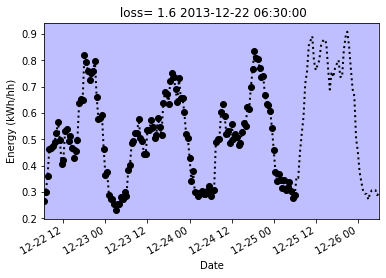

In [13]:
# Lets choose a challenging time to forecast
vis_i = 670 # 290 # 1600
plot_from_loader(loader_test, model, i=vis_i)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c593c9b70>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c593c9b70>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c593c9b70>
  File "/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
    w

0, i=0, loss: -1.272, test: 0.3633, grad_norm:  9, std:  0.085
0, i=100, loss: -1.099, test: 0.3568, grad_norm:  3.8, std:  0.1
0, i=200, loss: -1.136, test: 0.3577, grad_norm:  3.5, std:  0.095
0, i=300, loss: -1.091, test: 0.3527, grad_norm:  14, std:  0.1
0, i=400, loss: -1.194, test: 0.3533, grad_norm:  4.1, std:  0.095
0, i=500, loss: -1.114, test: 0.3531, grad_norm:  4.8, std:  0.087
0, i=600, loss: -1.262, test: 0.353, grad_norm:  2.4, std:  0.088
0, i=700, loss: -1.135, test: 0.3529, grad_norm:  9.4, std:  0.11
0, i=800, loss: -1.196, test: 0.3532, grad_norm:  2, std:  0.09
0, i=900, loss: -0.949, test: 0.3533, grad_norm:  9.6, std:  0.11
0, i=1000, loss: -1.097, test: 0.3537, grad_norm:  11, std:  0.11



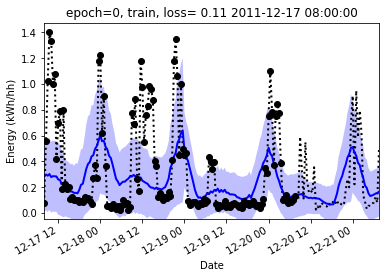

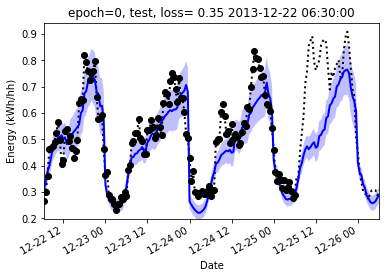

epoch: 0, loss: -1.663, loss_test:0.3539, kl=0.00054, grad_norm:  20


1, i=0, loss: -1.216, test: 0.3539, grad_norm:  11, std:  0.095
1, i=100, loss: -1.102, test: 0.3536, grad_norm:  1.8, std:  0.1
1, i=200, loss: -1.291, test: 0.3537, grad_norm:  3.1, std:  0.086
1, i=300, loss: -1.243, test: 0.3532, grad_norm:  6.7, std:  0.093
1, i=400, loss: -1.104, test: 0.3537, grad_norm:  4.1, std:  0.1
1, i=500, loss: -1.242, test: 0.3536, grad_norm:  14, std:  0.084
1, i=600, loss: -1.309, test: 0.3537, grad_norm:  3.9, std:  0.089
1, i=700, loss: -1.076, test: 0.3541, grad_norm:  3.1, std:  0.11
1, i=800, loss: -1.265, test: 0.3546, grad_norm:  6, std:  0.085
1, i=900, loss: -1.317, test: 0.3546, grad_norm:  18, std:  0.082
1, i=1000, loss: -1.214, test: 0.355, grad_norm:  2.4, std:  0.089



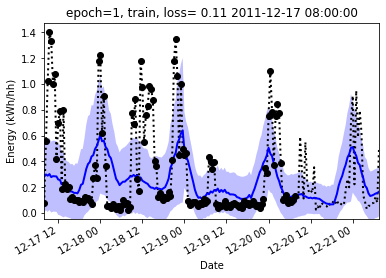

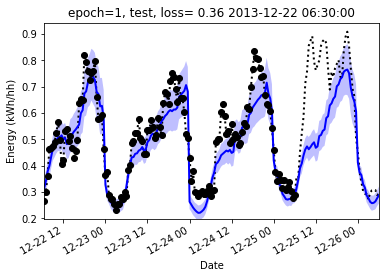

epoch: 1, loss: -1.267, loss_test:0.3556, kl=0.00034, grad_norm:  12


2, i=0, loss: -1.268, test: 0.3556, grad_norm:  4.5, std:  0.087
2, i=100, loss: -1.015, test: 0.3555, grad_norm:  4.6, std:  0.11
2, i=200, loss: -1.177, test: 0.355, grad_norm:  2.6, std:  0.092
2, i=300, loss: -1.001, test: 0.3549, grad_norm:  11, std:  0.11
2, i=400, loss: -1.087, test: 0.3553, grad_norm:  3.7, std:  0.11
2, i=500, loss: -1.475, test: 0.3553, grad_norm:  21, std:  0.076
2, i=600, loss: -1.247, test: 0.3553, grad_norm:  2.9, std:  0.088
2, i=700, loss: -1.151, test: 0.3556, grad_norm:  9.6, std:  0.095
2, i=800, loss: -1.336, test: 0.356, grad_norm:  3.3, std:  0.076
2, i=900, loss: -0.8478, test: 0.3558, grad_norm:  9.6, std:  0.12
2, i=1000, loss: -1.278, test: 0.356, grad_norm:  5, std:  0.082



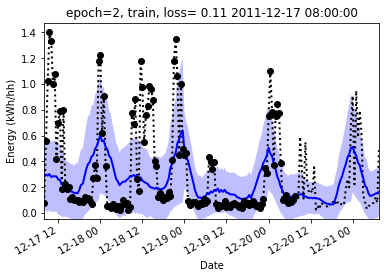

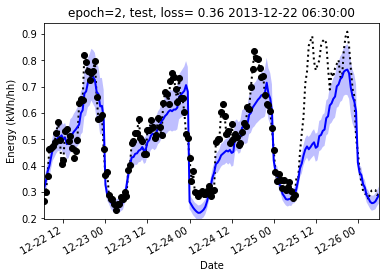

epoch: 2, loss: -1.282, loss_test:0.3562, kl=0.00047, grad_norm:  12


3, i=0, loss: -0.9849, test: 0.3562, grad_norm:  5, std:  0.13
3, i=100, loss: -1.028, test: 0.3557, grad_norm:  5.7, std:  0.11
3, i=200, loss: -1.109, test: 0.3556, grad_norm:  3.6, std:  0.095


In [ ]:
epochs = 30
grad_clip = 40
vis_i = 670
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, loss_mse, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%100==0:
            model.eval()
            test_loss = plot_from_loader(loader_test, model, i=vis_i, plot=False)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
            scheduler.step(loss.item())
        
    test_loss = plot_from_loader(loader_train, model, i=vis_i, title=f'epoch={epoch}, train,')
    plt.show()
    model.eval()
    test_loss = plot_from_loader(loader_test, model, i=vis_i, title=f'epoch={epoch}, test,')
    plt.show()
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item():2.2g}, grad_norm: {grad_norm: 2.2g}")

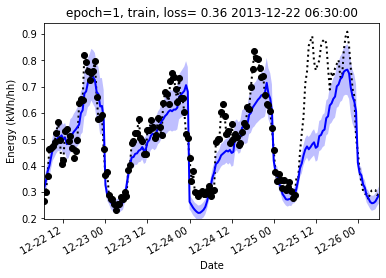

In [22]:
test_loss = plot_from_loader(loader_test, model, i=670, title=f'epoch={epoch}, train,')

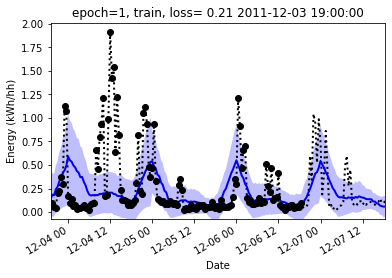

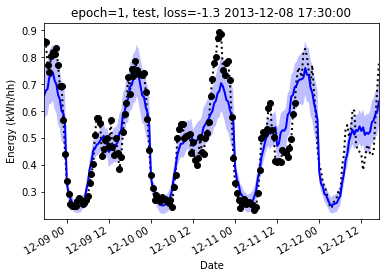

KeyboardInterrupt: 

In [23]:
for vis_i in [20, 50, 60, 70]:
    test_loss = plot_from_loader(loader_train, model, i=vis_i, title=f'epoch={epoch}, train,')
    plt.show()
    model.eval()
    test_loss = plot_from_loader(loader_test, model, i=vis_i, title=f'epoch={epoch}, test,')
    plt.show()

## History

In [ ]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['n']/(df_hist['epoch']+1)
df_hist.head(3)

In [ ]:
(df_hist[['loss', 'test_loss']]).plot(ylim=[-2,0])

In [ ]:
df_hist[['y_std']].plot(ylim=[0,1e4], logy=True)